In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool
from PIL import Image

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Saliency

In [2]:
def normalize(arr): return (arr - arr.mean()) / arr.std()

In [3]:
model_name = f"DenseNet121_v1_Cardiomegaly"
label = "Cardiomegaly"
s = 128
image_size = (s, s)#(224, 224)
labels = get_labels()
bs = 1
device = get_cpu()

Using the CPU!


In [4]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, 
                                             small=False)
print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df = get_binary_df(label, test_df)

train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
print(neg_weights, pos_weights)

train_tfs, test_tfs = get_transforms(image_size=image_size)

train_ds = CRX8_Data(train_df, get_image_path(), label, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), label, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), label, image_size=image_size, transforms=test_tfs)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)
dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

criterion = get_weighted_loss_with_logits(pos_weights.to(device), 
                                          neg_weights.to(device))

/home/favi/work/crx8/exp/utils.py:179: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


(69219, 24) (17305, 24) (25596, 24)
tensor([0.0198]) tensor([0.9802])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128]) torch.Size([1, 1]) tensor([[1.]])


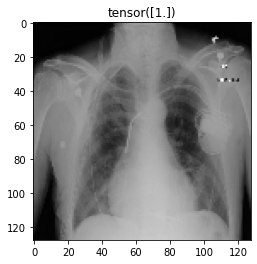

In [5]:
i = 0
pos_count = 0
target_pos = 6
X, y = get_batch(i, test_dl)
while True:
    if y.sum() > 0: pos_count += 1
    if pos_count == target_pos: break
    i += 1
    X, y = get_batch(i, test_dl)
print(X.shape, y.shape, y)
print_image(X[0], y[0])

In [6]:
model = load_model(model_name)
model.eval();

In [7]:
X, y, model = X.to(device), y.to(device), model.to(device)

In [8]:
saliency = Saliency(model)
grads = saliency.attribute(X, target=0)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

/home/favi/anaconda3/envs/crx8_pt/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [9]:
_, pred_label_idx = torch.topk(NN.Sigmoid()(model(X)), 1)

In [10]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=pred_label_idx, **kwargs)
    return tensor_attributions

In [11]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, X, baselines=X * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0131], dtype=torch.float64)


In [ ]:
array_info(attr_ig)

In [ ]:
def range_it(arr):
    arr += arr.min()
    arr /= arr.max()
    return arr

In [ ]:
plt.imshow(range_it(attr_ig))
array_info(range_it(attr_ig))

In [ ]:
attr_ig = Image.fromarray(attr_ig)
attr_ig = attr_ig.resize((1024, 1024), Image.BILINEAR)
attr_ig = np.array(attr_ig)

In [24]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attrs = []
for _ in range(20):
    tmp = attribute_image_features(nt, X, baselines=X * 0, 
                                          nt_type='smoothgrad_sq',
                                          nt_samples=5, stdevs=0.2)
    attrs.append(tmp[0].cpu().detach().numpy())
    array_info(tmp[0]);print()

attr_ig_nt = np.zeros((len(attrs), *attrs[0].shape))
for i in range(len(attrs)): attr_ig_nt[i] = attrs[i][0]
array_info(attr_ig_nt);print()
attr_ig_nt = attr_ig_nt.mean(axis=0)
array_info(attr_ig_nt);print()
attr_ig_nt = np.transpose(attr_ig_nt, (1, 2, 0))

Shape:	 torch.Size([3, 128, 128])
Mean:	 tensor(8.5742e-07, dtype=torch.float64)
Std:	 tensor(4.1259e-06, dtype=torch.float64)
Max:	 tensor(0.0002, dtype=torch.float64)
Min:	 tensor(2.4230e-14, dtype=torch.float64)

Shape:	 torch.Size([3, 128, 128])
Mean:	 tensor(9.0730e-07, dtype=torch.float64)
Std:	 tensor(4.5105e-06, dtype=torch.float64)
Max:	 tensor(0.0002, dtype=torch.float64)
Min:	 tensor(3.7403e-14, dtype=torch.float64)

Shape:	 torch.Size([3, 128, 128])
Mean:	 tensor(8.8176e-07, dtype=torch.float64)
Std:	 tensor(4.1479e-06, dtype=torch.float64)
Max:	 tensor(0.0002, dtype=torch.float64)
Min:	 tensor(9.4652e-15, dtype=torch.float64)

Shape:	 torch.Size([3, 128, 128])
Mean:	 tensor(8.8622e-07, dtype=torch.float64)
Std:	 tensor(4.1513e-06, dtype=torch.float64)
Max:	 tensor(0.0002, dtype=torch.float64)
Min:	 tensor(1.1490e-14, dtype=torch.float64)

Shape:	 torch.Size([3, 128, 128])
Mean:	 tensor(9.5825e-07, dtype=torch.float64)
Std:	 tensor(4.6572e-06, dtype=torch.float64)
Max:	 ten

In [ ]:
attr_ig_nt

In [ ]:
nt_trans = attr_ig_nt.mean(axis=-1)
array_info(nt_trans);print()

nt_trans = normalize(nt_trans)
nt_trans += nt_trans.min()
nt_trans /= nt_trans.max()
nt_trans *= 255
nt_trans = nt_trans.astype(np.uint8)

nt_trans = Image.fromarray(nt_trans).resize((1024, 1024), 
                                            Image.BILINEAR)
nt_trans = np.array(nt_trans)

array_info(nt_trans)

In [ ]:
or_im = X[0].cpu().detach().numpy()# * IMAGENET_STD + IMAGENET_MEAN
or_im *= 255
or_im = or_im.astype(np.uint8)
or_im = np.einsum("cwh -> whc", or_im)
array_info(or_im)

Image.fromarray(or_im)

In [ ]:
img1.paste(img2, (0,0), mask = img2)
  
# Displaying the image
img1.show()

In [ ]:
or_im = X[0].cpu().detach().numpy()
overl = or_im 

plt.imshow(nt_trans, cmap="gray")

In [ ]:
_ = viz.visualize_image_attr(grads, 
                             torch.einsum("cwh -> whc", X[0]).cpu().detach().numpy(), 
                             method="blended_heat_map", 
                             sign="absolute_value",
                             show_colorbar=True, 
                             title="Overlayed Gradient Magnitudes")

In [ ]:
euf = viz.visualize_image_attr(attr_ig, 
                            torch.einsum("cwh -> whc", X[0]).cpu().detach().numpy(), 
                             method="blended_heat_map", 
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Magnitudes")

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

fig = euf[0]
canvas = FigureCanvas(fig)
#ax = fig.gca()

#ax.text(0.0,0.0,"Test", fontsize=45)
#ax.axis('off')

canvas.draw()       # draw the canvas, cache the renderer

image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')



In [ ]:
np.sqrt(image.shape[0] / 3)
image = np.reshape(image, (432, 432, 3))
array_info(image)
plt.imshow(image)

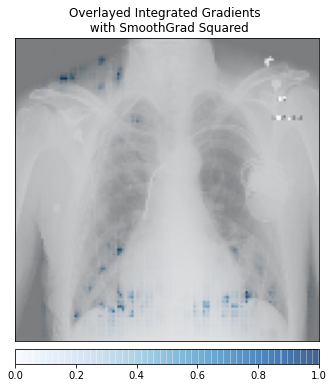

In [25]:
euf = viz.visualize_image_attr(attr_ig_nt, 
                             torch.einsum("cwh -> whc", X[0]).cpu().detach().numpy(), 
                             method="blended_heat_map", 
                             sign="absolute_value",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

In [ ]:
integrated_gradients = IntegratedGradients(model)

In [ ]:
attributions_ig = integrated_gradients.attribute(X, 
                                                 target=pred_label_idx, 
                                                 n_steps=200)


In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(X.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


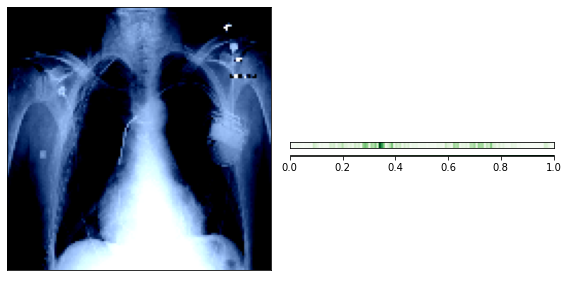

In [30]:
#noise_tunnel = NoiseTunnel(integrated_gradients)

#attributions_ig_nt = noise_tunnel.attribute(X, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attr_ig_nt),
                                      np.transpose(X[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                     # cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([X * 0, X * 1])

attributions_gs = gradient_shap.attribute(X,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(X[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
mappi = np.transpose(attributions_gs.squeeze().cpu().detach().numpy())
mappi = torch.einsum("whc -> cwh", torch.Tensor(mappi))
mappi.shape, X[0].shape

In [ ]:
im = np.einsum("cwh -> whc",  X[0].cpu().detach().numpy())
#im = (im * 255).astype(np.uint8)
ov = np.einsum("cwh -> whc", mappi.cpu().detach().numpy())
ov = normalize(ov)

pos_ov = ov.clip(min=0)
neg_ov = np.abs(ov.clip(max=0))

array_info(pos_ov, with_hist=True)
print()
array_info(neg_ov, with_hist=True)

im[0] = im[0] + im[0]*neg_ov.mean(axis=0)
im[1] = im[1] + im[1]*pos_ov.mean(axis=0)



#ov /= ov.max()
#array_info(ov)
#ov = (ov * 255).astype(np.uint8)
im.shape, ov.shape

In [ ]:
array_info(ov)

In [ ]:
plt.imshow(im)

In [ ]:
iii = Image.fromarray(ov)

In [ ]:
basewidth = s
img = iii.resize((1024, 1024), Image.BICUBIC)
plt.imshow(img, cmap="gray");

In [ ]:
print_image(X[0], 0)

In [ ]:
torch.einsum('bn,anm,bm->ba', l, A, r).shape

In [ ]:
bl = NN.Bilinear(s, s, 1024)

In [ ]:
bl(X[0], mappi)

In [ ]:
X[0].shape

In [ ]:
X[0] = X[0] * IMAGENET_STD

In [ ]:
def de_imagenet(arr): 
    if len(arr.shape) == 3:
        for i in range(3):
            arr[i] = arr[i] * IMAGENET_STD[i] + IMAGENET_MEAN[i]
    if len(arr.shape) == 4:
        for i in range(3):
            arr[:, i] = arr[:, i] * IMAGENET_STD[i] + IMAGENET_MEAN[i]
    return arr

In [ ]:
de_imagenet(X[0])

In [ ]:
IMAGENET_STD

In [ ]:
print_image(X[0], y[0])

In [ ]:
array_info(X[0], with_hist=False)

In [ ]:
pos_grads = (normalize(attributions_ig[0].clip(min=0)) * X[0]).mean(axis=0)
neg_grads = (normalize(attributions_ig[0].clip(max=0)) * X[0]).mean(axis=0)
im = X[0].mean(axis=0)
overlay_im = torch.ones((*pos_grads.shape, 3))

for i, p in enumerate([im, im, im]): 
    overlay_im[:, :, i] = overlay_im[:, :, i] * p
    if i == 0: overlay_im[:, :, i] = (overlay_im[:, :, i] + pos_grads)/2.

plt.imshow(overlay_im)

In [ ]:
neg_grads.mean(axis=(0)).shape

In [ ]:
comb = normalize(attributions_ig[0]) * X[0]
array_info(attributions_ig[0])
print()
array_info(attributions_ig[0].clip(min=0))
print()
array_info(comb)

In [ ]:
print_image(pos_grads , y[0])

In [ ]:
print_image(neg_grads , y[0])

In [ ]:
print_image(attributions_ig[0], y[0])

In [ ]:
print_image(attributions_ig[0] * X[0], y[0])

In [ ]:
array_info(attributions_ig[0], with_hist=False)